# Using Stable Diffusion XL base model and Refiner model 

SDXL consists of an ensemble of experts pipeline for latent diffusion: 
1. In a first step, the base model is used to generate (noisy) latents. 
2. which are then further processed with a refinement model specialized for the final denoising steps. 

* base model can also be used as a standalone module.

Thanks to [HuggingFace](https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0)!


Other notebooks :

[Basics of Diffusers (Huggingface)](https://www.kaggle.com/code/rumbare/basics-of-diffusers-huggingface)    first go through this notebook for complete understanding of this notebook.


[Automatic1111 stable diffusion webui using kaggle and Ngrok](https://www.kaggle.com/code/rumbare/automatic1111-stable-diffusion-webui-for-begginers/notebook)

In [1]:
pip install diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.4 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
from diffusers import DiffusionPipeline  # importing diffusionPipeline  dont use AutoPipeline it might not work
import torch  # ML framework, we will see how to use it here!

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

# Base + Refiner Model

1. For using base plus refiner model it is important to have both models in single GPU. otherwise it generates error

In [3]:
base_model = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",  # you can find this ID on hugging face, just search for base model
    use_safetensors = True,# Redundant here but, still good practice
    torch_dtype = torch.float16,# Configuring the torch data type to float16 for half precision, suitable for memory efficiency and faster computations.
    variant = "fp16" # otherwise 10GB variant will load
)

base_model.to("cuda")  # load base model into cuda device 0


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

2024-02-17 01:59:17.972433: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-17 01:59:17.972563: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-17 01:59:18.132189: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.26.3",
  "_name_or_path": "stabilityai/stable-diffusion-xl-base-1.0",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

# Here We will load a refiner model 
*reusing the base model's text encoder and vae eliminates the need to load and process through a separate one for the refiner, boosting efficiency*

In [4]:
refiner_model = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0",  # You can find it on huggingface
    text_encoder_2=base_model.text_encoder_2, # we are using same tokenizer as that of base model as said above
    vae=base_model.vae ,# using vae of base model
    torch_dtype=torch.float16, # Already explained in base model
    use_safetensors=True, 
    variant="fp16",
)


refiner_model.to("cuda")  #loading refiner model into cuda. 

# base and refiner must be in same device 

model_index.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer_2/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/4.52G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

StableDiffusionXLImg2ImgPipeline {
  "_class_name": "StableDiffusionXLImg2ImgPipeline",
  "_diffusers_version": "0.26.3",
  "_name_or_path": "stabilityai/stable-diffusion-xl-refiner-1.0",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": false,
  "image_encoder": [
    null,
    null
  ],
  "requires_aesthetics_score": true,
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    null,
    null
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    null,
    null
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

# Defining Parameters

In [31]:
#Prompt : simply it is a guide for generation, in complex words a text encoders creates embeddings from prompts
prompt = "(Bag end, the shire city,hobbiton, hobbit village,lord of rings movie,  Peter Jackson movie, high res)"

height = 1024 # Default and recommended
width = 1024 # Default
# no need to pass height width for default values

num_inference_steps = 50 # point to note here is it is combined steps of base + refiner
denoising_factor = 0.8 # it divides steps between base model and refiner model
# base model steps = 0.8*50 
# refiner model steps = 0.2*50

In [32]:

latent_image = base_model(
    prompt=prompt,
    num_inference_steps=num_inference_steps, 
    denoising_end=denoising_factor,  # end the denoising using base model at 80% of total steps
    output_type="latent", # output should be of latent type not pixel image
).images

torch.cuda.empty_cache() # it will clear the cache in GPU. Cacbe must be cleared time to time, especiallly using base+refiner combo

  0%|          | 0/40 [00:00<?, ?it/s]

**Here output of base latent_image.
lets see what it looks like

In [33]:
latent_image

tensor([[[[-0.5820, -1.7666, -1.2559,  ...,  0.3921, -0.5815,  0.9434],
          [-0.8926, -1.7412, -1.4668,  ..., -1.0400, -0.6411, -0.7666],
          [-2.0859, -0.5005, -0.8560,  ..., -0.6611, -0.9746, -0.0592],
          ...,
          [-2.0352, -0.7744, -1.2988,  ...,  0.3931,  0.0615,  0.2360],
          [-0.4802, -1.3047, -0.6753,  ..., -0.5269, -0.4570, -0.3818],
          [-0.6689, -0.5029, -0.0173,  ..., -0.7070, -0.4707, -0.5244]],

         [[-0.3977, -0.6089,  1.1094,  ...,  0.3381,  1.2256,  1.2041],
          [-0.9980, -0.1272, -0.3091,  ...,  0.8291,  1.8008,  1.5723],
          [-0.3545,  1.3027, -0.6240,  ...,  1.2236,  1.6582,  0.9062],
          ...,
          [-0.8071,  0.4756,  0.0618,  ..., -0.5630,  0.7773,  0.4956],
          [ 1.3086, -0.2175,  0.6362,  ...,  0.5376, -1.4814, -0.5078],
          [ 0.2141,  1.0986, -0.8442,  ...,  0.5107,  0.6904, -0.1600]],

         [[-1.8096, -1.3574,  0.2505,  ...,  0.0458, -0.1555, -0.2927],
          [-0.5923, -0.7168, -

**basically it is just vector of vectors having floating pointers in range -1 to 1**

## now we will use refiner model to generate image(refined)

**Here point to remember is that we are using every parameter same as base model**

In [34]:
final_image = refiner_model(
    prompt=prompt,
    num_inference_steps=num_inference_steps, 
    # Denoising started after 80% work done by base model now refiner will just do the remaining work
    denoising_start=denoising_factor,                             
    image=latent_image,  #it will use the latent image generated by base model as its input
).images[0]

#dont forget to clear cache otherwise cuda will go out of memory
torch.cuda.empty_cache()

  0%|          | 0/10 [00:00<?, ?it/s]

Now we have final image generated after going through base and refiner

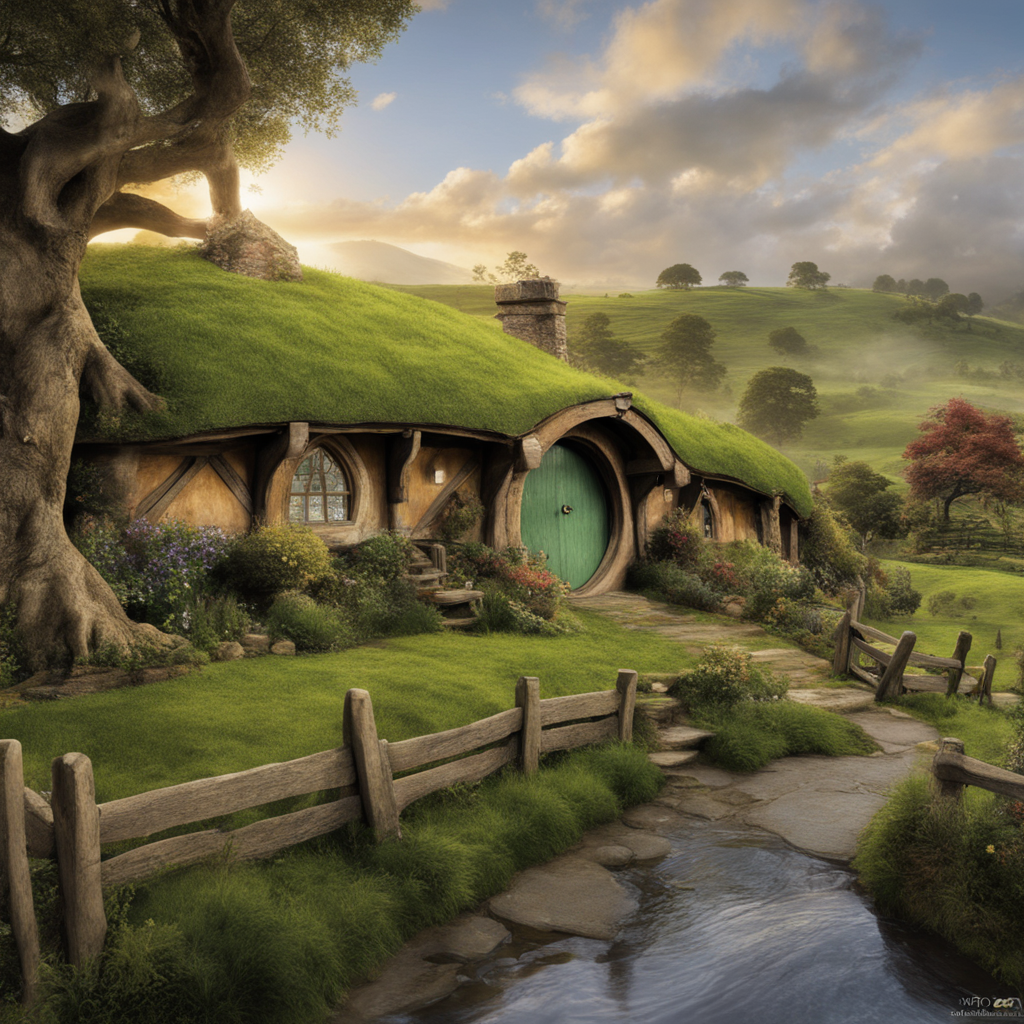

In [35]:
final_image

# Optional

we can create function returning image
